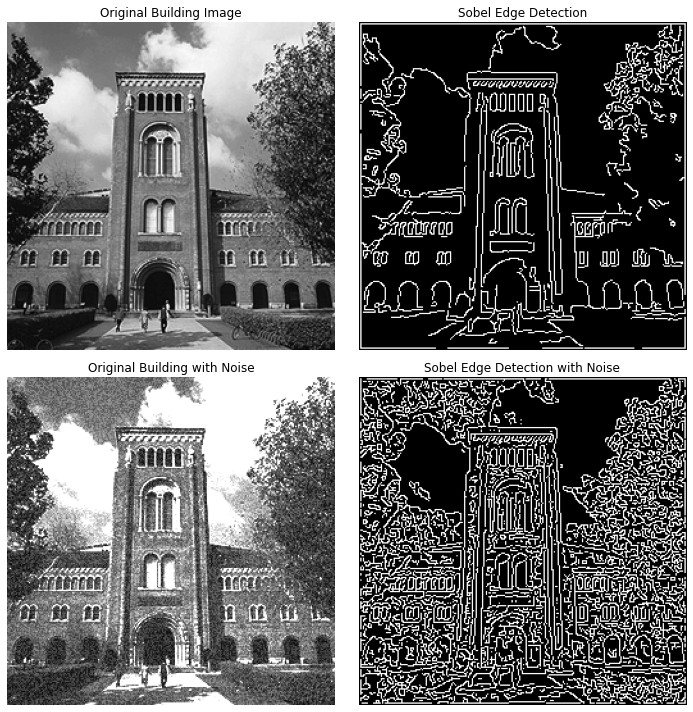

In [13]:
import numpy as np
from scipy import ndimage
from skimage import feature
import matplotlib.pyplot as plt

# Consolidating the edge detection methods into one with a parameter to switch between methods
def edge_detection(image, method='sobel', sigma=1.0):
    if method == 'sobel':
        return feature.canny(image, sigma=sigma)
    elif method == 'log':
        blurred = ndimage.gaussian_filter(image, sigma=sigma)
        laplacian = ndimage.laplace(blurred)
        zero_crossings = np.where(np.diff(np.sign(laplacian), axis=0), 1, 0)
        return zero_crossings

# We load the images only once as they are used multiple times.
# We also pass the shape as a parameter to make the function more general.
def load_and_process_image(file_path, shape=(256, 256), method='sobel', sigma=1.0):
    try:
        # Load image from file
        with open(file_path, 'rb') as rawfile:
            img = np.fromfile(rawfile, dtype=np.uint8).reshape(shape)
        # Process image
        edges = edge_detection(img, method=method, sigma=sigma)
        return img, edges
    except IOError:
        print(f"Error: File {file_path} not accessible.")
        return None, None

# Load the images and process them
building_image, edges_building = load_and_process_image('./Project2_Images/building.raw')
building_noise_image, edges_building_noise = load_and_process_image('./Project2_Images/building_noise.raw')
_, edges_building_log = load_and_process_image('./Project2_Images/building.raw', method='log', sigma=2)
_, edges_building_noise_log = load_and_process_image('./Project2_Images/building_noise.raw', method='log', sigma=2)

# Check if images were loaded successfully before proceeding to plot
if building_image is not None and building_noise_image is not None:
    # Plot the results using a more concise loop
    titles = ['Original Building Image', 'Sobel Edge Detection',
              'Original Building with Noise', 'Sobel Edge Detection with Noise']
    images = [building_image, edges_building, building_noise_image, edges_building_noise]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap=plt.cm.gray)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


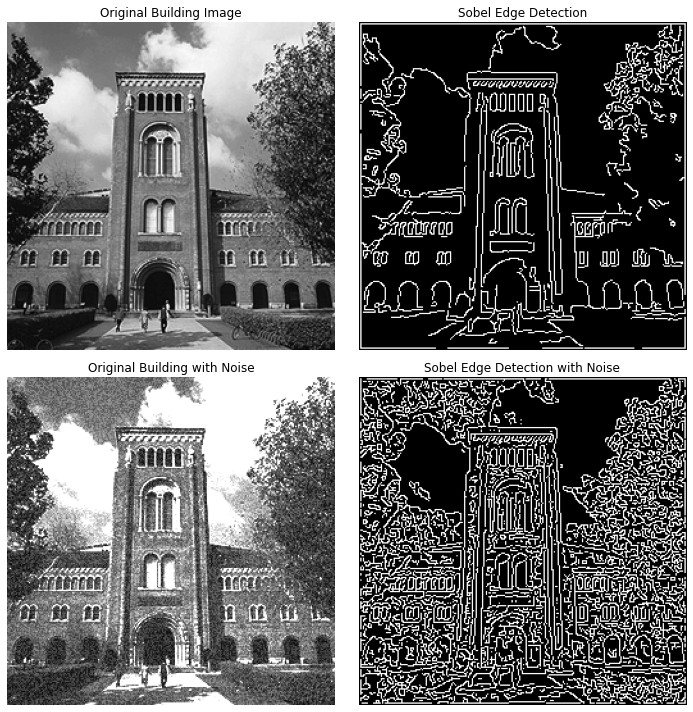

In [16]:
import numpy as np
from scipy import ndimage
from skimage import feature, exposure, morphology, filters
import matplotlib.pyplot as plt

def edge_detection(image, method='sobel', sigma=1.0):
    if method == 'sobel':
        return feature.canny(image, sigma=sigma)
    elif method == 'log':
        blurred = ndimage.gaussian_filter(image, sigma=sigma)
        laplacian = ndimage.laplace(blurred)
        zero_crossings = np.where(np.diff(np.sign(laplacian), axis=0), 1, 0)
        return zero_crossings

def pre_process_image(image, method='equalization'):
    if method == 'equalization':
        # Histogram Equalization
        return exposure.equalize_hist(image)
    elif method == 'clahe':
        # Contrast Limited Adaptive Histogram Equalization
        clahe = exposure.equalize_adapthist(image, clip_limit=0.03)
        return clahe

def post_process_edges(edges, min_size=64):
    # Remove small objects
    cleaned_edges = morphology.remove_small_objects(edges.astype(bool), min_size=min_size)
    return cleaned_edges

def remove_noise(image, method='gaussian', sigma=1.0):
    if method == 'gaussian':
        # Gaussian Blur
        return ndimage.gaussian_filter(image, sigma=sigma)
    elif method == 'median':
        # Median Filter
        return filters.median(image)

# ... existing load_and_process_image function ...

# Example usage in your existing loading and plotting section:
# Pre-process the image for contrast enhancement
building_image_eq = pre_process_image(building_image, method='equalization')
building_noise_image_denoised = remove_noise(building_noise_image, method='median', sigma=2)

# Edge detection on the pre-processed images
# ... existing functions ...

# Edge detection on the pre-processed images
edges_building_eq = edge_detection(building_image_eq, method='sobel', sigma=1)
edges_building_noise_denoised = edge_detection(building_noise_image_denoised, method='sobel', sigma=1)

# Post-process the edges to clean up
edges_building_eq_post = post_process_edges(edges_building_eq)
edges_building_noise_denoised_post = post_process_edges(edges_building_noise_denoised)

if building_image is not None and building_noise_image is not None:
    # Plot the results using a more concise loop
    titles = ['Original Building Image', 'Sobel Edge Detection',
              'Original Building with Noise', 'Sobel Edge Detection with Noise']
    images = [building_image, edges_building, building_noise_image, edges_building_noise]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap=plt.cm.gray)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

